# Junwon (Paul) Park

# Data Set Creator

In [1]:
import pandas as pd
import os
import sys
from datetime import datetime

def dataset_creator(raw_data_path='0_meal_identification/meal_identification/data/raw',
                    output_dir='0_meal_identification/meal_identification/data/interim',
                    use_auto_label=True,
                    keep_cols=['date', 'bgl', 'msg_type', 'affects_fob', 'affects_iob','dose_units','food_g','food_glycemic_index'],
                    day_start_index_change=True,
                    day_start_time=pd.Timedelta(hours=4),
                    min_carbs=10,
                    n_top_carb_meals=3,
                    meal_length=pd.Timedelta(hours=3),
                    erase_meal_overlap=True,
                    coerce_time=True,
                    coerse_time_interval=pd.Timedelta(minutes=5),
                    return_data=False,
                    ):
    '''
    Create a dataset from the raw data.

    Parameters
    ----------
    raw_data_path : str, optional
        Path to the directory containing raw data files (default is 'data/raw').
    output_dir : str, optional
        Directory to save the processed dataset (default is 'data/interm').
    use_auto_label : bool, optional
        Whether to use the auto label for the dataset (default is True).
    keep_cols : list of str, optional
        List of columns to keep from the raw data (default is ['date', 'bgl', 'msg_type', 'affects_fob', 'affects_iob', 'dose_units', 'food_g', 'food_glycemic_index']).
    day_start_index_change : bool, optional
        Whether to create a day index starting at a specific time (default is True).
    day_start_time : pd.Timedelta, optional
        The time of day to start the day index (default is pd.Timedelta(hours=4)).
    min_carbs : int, optional
        Minimum amount of carbohydrates to consider a meal (default is 10).
    n_top_carb_meals : int, optional
        Number of top carbohydrate meals to consider per day, keeps the 'n' largest aggregated meals (default is 3).
    meal_length : pd.Timedelta, optional
        Duration of a meal (default is pd.Timedelta(hours=3)).
    erase_meal_overlap : bool, optional
        Whether to erase overlapping meals (default is True).
    coerce_time : bool, optional
        Whether to use coarse time intervals (default is True).
    coerse_time_interval : pd.Timedelta, optional
        Interval for coarse time (default is pd.Timedelta(minutes=5)).
    return_data : bool, optional
        Whether to return the processed data (default is False).

    Returns
    -------
    None
        The function processes the raw data and saves the dataset to the specified output directory.
    '''

    def get_root_dir(current_dir=None):
        '''
        Get the root directory of the project by looking for a 'bg_control' directory.

        Parameters
        ----------
        current_dir : str, optional
            The starting directory to search from. If None, uses the current working directory.

        Returns
        -------
        str
            The root directory of the project.
        '''
        if current_dir is None:
            current_dir = os.getcwd()

        while current_dir != os.path.dirname(current_dir):
            if os.path.basename(current_dir) == 'bg_control':
                return current_dir
            current_dir = os.path.dirname(current_dir)

        raise FileNotFoundError("Project root directory 'bg_control' not found.")

    def load_data(raw_data_path, keep_cols):
        '''
        Load data from the raw data path.

        Parameters
        ----------
        raw_data_path : str
            Path to the directory containing raw data files.
        keep_cols : list of str
            List of columns to keep from the raw data.

        Returns
        -------
        dict
            A dictionary of DataFrames loaded from the raw data files.
        '''
        project_root = get_root_dir()
        print(project_root)
        full_raw_loc_path = os.path.join(project_root, raw_data_path)
        print(full_raw_loc_path)
        csv_files = [f for f in os.listdir(full_raw_loc_path) if f.endswith('.csv')]
        columns_to_load = keep_cols

        # Load each CSV file into a DataFrame and store them in a dictionary
        dataframes = {file: pd.read_csv(os.path.join(full_raw_loc_path, file), usecols=columns_to_load, parse_dates=['date']) for file in csv_files}
        print("Loaded DataFrames:", list(dataframes.keys()))

        return dataframes

    def save_data(data,
                  output_dir='0_meal_identification/meal_identification/data/interim',
                  data_label='dataLabelUnspecified_',
                  patient_id='idUnspecified_',
                  data_gen_date=datetime.today().strftime('%Y-%m-%d'),
                  inclue_gen_date_label=True):
        '''
        Save the data to the output directory

        Parameters
        ----------
        data : pd.DataFrame
            The data to save
        output_dir : str
            The directory to save the data
        data_label : str
            The label for the data
        patient_id : str
            The patient ID
        data_gen_date : str
            The date the data was generated
        inclue_gen_date_label : bool
            Whether to include the data generation date in the label

        Returns
        -------
        None
            The function saves the data to the specified output directory
        '''
        project_root = get_root_dir()
        print(f"Project root: {project_root}")
        full_out_path_dir = os.path.join(project_root, output_dir)
        if inclue_gen_date_label:
            data.to_csv(os.path.join(full_out_path_dir, f"{data_gen_date}_{patient_id}_{data_label}.csv"), index=True)
            print(f"Data saved successfully in: {output_dir}")
            print(f"\n \t Dataset label: {data_gen_date}_{patient_id}__{data_label}")
        else:
            data.to_csv(os.path.join(full_out_path_dir, f"{patient_id}_{data_label}.csv"), index=True)
            print(f"Data saved successfully in: {output_dir}")
            print(f"\n \t Dataset label: {patient_id}_{data_label}")

    def dataset_label_modifier_fn(base_label_modifer, coerce_time, coerce_time_label, day_start_index_change, day_start_time_label, erase_meal_overlap, erase_meal_label):
        '''
        Modify the data label

        Parameters
        ----------
        base_label_modifer : str
            The base label modifier for the dataset
        coerce_time : bool
            Whether to coerce the time interval of the data
        coerce_time_label : str
            The label modifier for the time interval coercion
        day_start_index_change : bool
            Whether to create a day index starting at a specific time
        day_start_time_label : str
            The label modifier for the day start time
        erase_meal_overlap : bool
            Whether to erase overlapping meals
        erase_meal_label : str
            The label modifier for the meal overlap erasure

        Returns
        -------
        str
            The modified data label
        '''
        data_label_modifer = base_label_modifer
        if coerce_time:
            data_label_modifer = data_label_modifer + coerce_time_label
        if day_start_index_change:
            data_label_modifer = data_label_modifer + day_start_time_label
        if erase_meal_overlap:
            data_label_modifer = data_label_modifer + erase_meal_label

        return data_label_modifer

    def coerce_time_fn(data, coerse_time_interval):
        '''
        Coerce the time interval of the data
        '''
        data = data.set_index('date').squeeze()
        data.index = pd.DatetimeIndex(data.index)
        data = data.resample(coerse_time_interval).first()

        meal_annoucements_df = data[data['msg_type'] == 'ANNOUNCE_MEAL']
        meal_annoucements_df = meal_annoucements_df.resample('5min').first()
        non_meal_df = data[data['msg_type'] != 'ANNOUNCE_MEAL']
        non_meal_df = non_meal_df.resample('5min').first()

        data_resampled = non_meal_df.join(meal_annoucements_df, how='left', rsuffix='_meal')
        data_resampled['bgl'] = data_resampled['bgl_meal'].combine_first(data_resampled['bgl'])
        data_resampled['msg_type'] = data_resampled['msg_type_meal'].combine_first(data_resampled['msg_type'])
        data_resampled['food_g'] = data_resampled['food_g_meal'].combine_first(data_resampled['food_g'])
        data_resampled['food_g_keep'] = data_resampled['food_g_meal']
        # Identify columns that end with '_meal'
        columns_to_drop = data_resampled.filter(regex='_meal$').columns

        # Drop the identified columns
        data_resampled = data_resampled.drop(columns=columns_to_drop)
        return data_resampled

    def erase_meal_overlap_fn(patient_df, meal_length, min_carbs):
        '''
        Process the DataFrame to handle meal overlaps.

        Parameters
        ----------
        df : pd.DataFrame
            The input DataFrame with columns 'msg_type', 'food_g', and a datetime index.
        meal_length : pd.Timedelta
            The duration to look ahead for meal events.

        Returns
        -------
        pd.DataFrame
            The processed DataFrame with meal overlaps handled.
        '''

        announce_meal_indices = patient_df[patient_df['msg_type'] == 'ANNOUNCE_MEAL'].index
        patient_df[patient_df['msg_type'] == 'ANNOUNCE_MEAL']

        for idx in announce_meal_indices:
            # We do not want to consider meals that are less than the minimum carbs
            #   min carbs are okay if they are rolled into a larger meal, but they should
            #   not count as the start of a meal.
            if patient_df.at[idx, 'food_g'] <= min_carbs:
                 continue

            # Define the time window
            window_end = idx + meal_length

            # Get the events within the time window
            window_events = patient_df.loc[idx+pd.Timedelta(1):window_end]

            # Sum the 'food_g' counts greater than 0 within the window
            food_g_sum = window_events[window_events['food_g'] > 0]['food_g'].sum()

            # Add the sum to the original 'ANNOUNCE_MEAL' event
            patient_df.at[idx, 'food_g'] += food_g_sum

            # Erase the other events that fell within the window
            patient_df.loc[window_events.index[:], 'food_g'] = 0
            patient_df.loc[window_events.index[:], 'msg_type'] = ''

        return patient_df

    def keep_top_n_carb_meals(patient_df, n_top_carb_meals):
        '''
        Keep only the top n carbohydrate meals per day in the DataFrame.

        Parameters
        ----------
        df : pd.DataFrame
            The input DataFrame with columns 'msg_type', 'food_g', and a datetime index.
        n_top_carb_meals : int
            The number of top carbohydrate meals to keep per day.

        Returns
        -------
        pd.DataFrame
            The processed DataFrame with only the top n carbohydrate meals per day.
        '''
        # Filter the DataFrame to include only 'ANNOUNCE_MEAL' events
        announce_meal_df = patient_df[patient_df['msg_type'] == 'ANNOUNCE_MEAL']

        # Group by date
        grouped = announce_meal_df.groupby('day_start_shift')
        # Initialize a list to store the indices of the top n meals
        top_meal_indices = []

        for date, group in grouped:
            # Sort the group by 'food_g' in descending order and keep the top n meals
            top_meals = group.nlargest(n_top_carb_meals, 'food_g')
            top_meal_indices.extend(top_meals.index)

        # Set the 'food_g' values of the other meals to 0
        patient_df.loc[~patient_df.index.isin(top_meal_indices) & (patient_df['msg_type'] == 'ANNOUNCE_MEAL'), 'food_g'] = 0
        patient_df.loc[~patient_df.index.isin(top_meal_indices) & (patient_df['msg_type'] == 'ANNOUNCE_MEAL'), 'msg_type'] = '0'
        return patient_df

    # MAIN FUNCTION
    patient_dfs_dict = load_data(raw_data_path=raw_data_path, keep_cols=keep_cols)

    if return_data:
        patient_dfs_list = []

    for patient_key in patient_dfs_dict.keys():
        print(f"\n========================= \nProcessing: {patient_key[:6]}")
        patient_df = patient_dfs_dict[patient_key]

        if coerce_time:
            patient_df = coerce_time_fn(data=patient_df, coerse_time_interval=coerse_time_interval)

        if day_start_index_change:
            adjusted_date = patient_df.index - day_start_time
            patient_df['day_start_shift'] = adjusted_date.date

        if erase_meal_overlap:
            print(f"Erasing meal overlap with minCarb{min_carbs}g and {meal_length.components.hours}hr meal window")
            patient_df = erase_meal_overlap_fn(patient_df, meal_length, min_carbs)

        if n_top_carb_meals != -1:
            patient_df = keep_top_n_carb_meals(patient_df, n_top_carb_meals=n_top_carb_meals)

        if use_auto_label:
            save_data(data=patient_df,
                      data_label=dataset_label_modifier_fn(base_label_modifer=''
                                                           , coerce_time=coerce_time
                                                           , coerce_time_label='timeInter'+str(coerse_time_interval.components.minutes)+'mins_'
                                                           , day_start_index_change=day_start_index_change
                                                           , day_start_time_label="dayStart"+str(day_start_time.components.hours)+"hrs_"
                                                           , erase_meal_overlap=erase_meal_overlap
                                                           , erase_meal_label='minCarb'+str(min_carbs)+'g_'+str(meal_length.components.hours)+'hrMealW'
                                                           ),
                      patient_id=patient_key[:7])
        else:
            save_data(data=patient_df, patient_id=patient_key[:7])

        if return_data:
            patient_dfs_list.append(patient_df)

    print(f"\n\n All data saved successfully in: {output_dir}")
    if return_data:
        return patient_dfs_list
    else:
        return None

In [2]:
result_df = dataset_creator(return_data=True)
walker_df = result_df[0]
christopher_df = result_df[1]

c:\Users\06pau\Downloads\GitHub\bg_control
c:\Users\06pau\Downloads\GitHub\bg_control\0_meal_identification/meal_identification/data/raw
Loaded DataFrames: ['500030_2024-07-01_2024-09-30.csv', '679372_2024-07-01_2024-09-30.csv']

Processing: 500030
Erasing meal overlap with minCarb10g and 3hr meal window
Project root: c:\Users\06pau\Downloads\GitHub\bg_control
Data saved successfully in: 0_meal_identification/meal_identification/data/interim

 	 Dataset label: 2024-11-10_500030___timeInter5mins_dayStart4hrs_minCarb10g_3hrMealW

Processing: 679372
Erasing meal overlap with minCarb10g and 3hr meal window
Project root: c:\Users\06pau\Downloads\GitHub\bg_control
Data saved successfully in: 0_meal_identification/meal_identification/data/interim

 	 Dataset label: 2024-11-10_679372___timeInter5mins_dayStart4hrs_minCarb10g_3hrMealW


 All data saved successfully in: 0_meal_identification/meal_identification/data/interim


# Data Exploration

## Data Information

| Column Name            | Description                                                                                                    | Relevance to STRAY for Anomaly Detection                                                                                 |
|------------------------|----------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------|
| **bgl**                | Blood glucose level (primary explanatory variable for blood glucose trends and anomalies).                     | Essential for STRAY as it forms the main data series to detect anomalies (e.g., unusual highs or lows in blood glucose). |
| **msg_type**           | Indicates the type of message (e.g., ANNOUNCE_MEAL, DOSE_INSULIN). Only `ANNOUNCE_MEAL` is of interest here.  | This is what we are predicting    |
| **affects_fob**        | Boolean indicating if food is on board, usually true for meal-related entries.                                 | Could help in filtering out or isolating anomalies linked to meal intake patterns in blood glucose.                      |
| **affects_iob**        | Boolean indicating if insulin is on board, useful for insulin administration tracking.                         | Relevant for identifying anomalies during or after insulin action, giving insight into unexpected glucose responses.     |
| **dose_units**         | Number of insulin units administered.                                                                         | Useful for anomaly detection in glucose following insulin doses, particularly if an expected drop is not observed.       |
| **food_g**             | Amount of carbohydrates (grams) logged during meal events.                                                     | Can contextualize anomalies by linking high glucose levels with large carbohydrate intake.                               |
| **food_glycemic_index**| Glycemic index of the carbs (low or high).                                                                    | May explain glucose spikes for high glycemic index meals; relevant for distinguishing between types of food intake.      |
| **food_g_keep**        | Auxiliary column to track adjusted food grams after meal processing.                                          | Less critical for anomaly detection but could assist in refining meal-related data if included.                         |
| **day_start_shift**    | Custom day start (e.g., 4 AM) for grouping events within a specific day structure.                            | Not directly relevant to STRAY but provides a temporal reference for daily grouping if needed for additional analyses.   |


# Data prep function

Handling null values as 0

Changing binary values as 0 and 1

In [25]:
def data_prep(df, relevant_msg_types= ['ANNOUNCE_MEAL', 'INTERVENTION_SNACK', 'ANNOUNCE_EXERCISE', 'DOSE_INSULIN', 'DOSE_BASAL_INSULIN']):
    """
    Preprocess the DataFrame by:
    1. Replacing all NaN values with 0.
    2. Converting binary columns with True/False values to 1/0.
    3. Expanding the 'msg_type' column into separate binary columns for each relevant message type.

    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame to preprocess.
    relevant_msg_types : list of str, optional
        List of relevant message types to expand into separate columns.
        If None, defaults to ['ANNOUNCE_MEAL', 'INTERVENTION_SNACK', 'ANNOUNCE_EXERCISE', 'DOSE_INSULIN', 'DOSE_BASAL_INSULIN'].

    Returns
    -------
    pd.DataFrame
        The processed DataFrame with NaN replaced by 0, binary values adjusted, and relevant message types expanded.
    """
    # Replace all NaN values with 0
    df = df.fillna(0)
    
    # Convert binary True/False values to 1/0
    binary_columns = df.select_dtypes(include=['bool']).columns
    df[binary_columns] = df[binary_columns].astype(int)
    
    for msg_type in relevant_msg_types:
        df[msg_type] = (df['msg_type'] == msg_type).astype(int)
    
    # Drop the original 'msg_type' column if no longer needed
    df = df.drop(columns=['msg_type'])
    
    return df

In [23]:
walker_df['msg_type'].unique()

array([0, '0', 'DOSE_INSULIN', 'INTERVENTION_SNACK', 'TEXT',
       'ANNOUNCE_MEAL', '', 'DOSE_BASAL_INSULIN', 'ANNOUNCE_EXERCISE',
       'BGL_FP_READING', 'BGL_FP_READING_CGM_CALIBRATION', 'NEW_SENSOR',
       'DOSE_MEDICINE'], dtype=object)

In [26]:
walker_df = data_prep(walker_df)

# Plot for BGL level and Meal time and Dose Insulin

In [37]:
import matplotlib.pyplot as plt

def plot_bgl_with_events(df, start_date="2024-07-15", end_date="2024-07-20"):
    """
    Plot blood glucose level (bgl) over time with annotations for ANNOUNCE_MEAL and DOSE_INSULIN events.
    Data is filtered to a specific date range and separated by 'day_start_shift'.

    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame containing blood glucose levels, ANNOUNCE_MEAL, and DOSE_INSULIN columns.
    start_date : str, optional
        The start date for the plot range (default is "2024-07-15").
    end_date : str, optional
        The end date for the plot range (default is "2024-07-20").

    Returns
    -------
    None
    """
    # Filter data based on the specified date range
    mask = (df.index >= start_date) & (df.index <= end_date)
    filtered_df = df[mask]
    
    # Set up the plot
    plt.figure(figsize=(14, 7))
    
    # Plot the blood glucose levels (bgl) against the date index
    plt.plot(filtered_df.index, filtered_df['bgl'], label='Blood Glucose Level (bgl)', color='blue')
    plt.xlabel('Date')
    plt.ylabel('Blood Glucose Level (bgl)')
    plt.title(f'Blood Glucose Level with Meal and Insulin Events from {start_date} to {end_date}')
    
    # Mark events for ANNOUNCE_MEAL with red vertical lines
    announce_meal_events = filtered_df[filtered_df['ANNOUNCE_MEAL'] == 1].index
    for event in announce_meal_events:
        plt.axvline(x=event, color='red', linestyle='--', alpha=0.7, label='ANNOUNCE_MEAL (Red)')
    
    # Mark events for DOSE_INSULIN with green vertical lines
    dose_insulin_events = filtered_df[filtered_df['DOSE_INSULIN'] == 1].index
    for event in dose_insulin_events:
        plt.axvline(x=event, color='green', linestyle='--', alpha=0.7, label='DOSE_INSULIN (Green)')
    
    # Remove duplicate labels in the legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    
    # Show the plot
    plt.show()


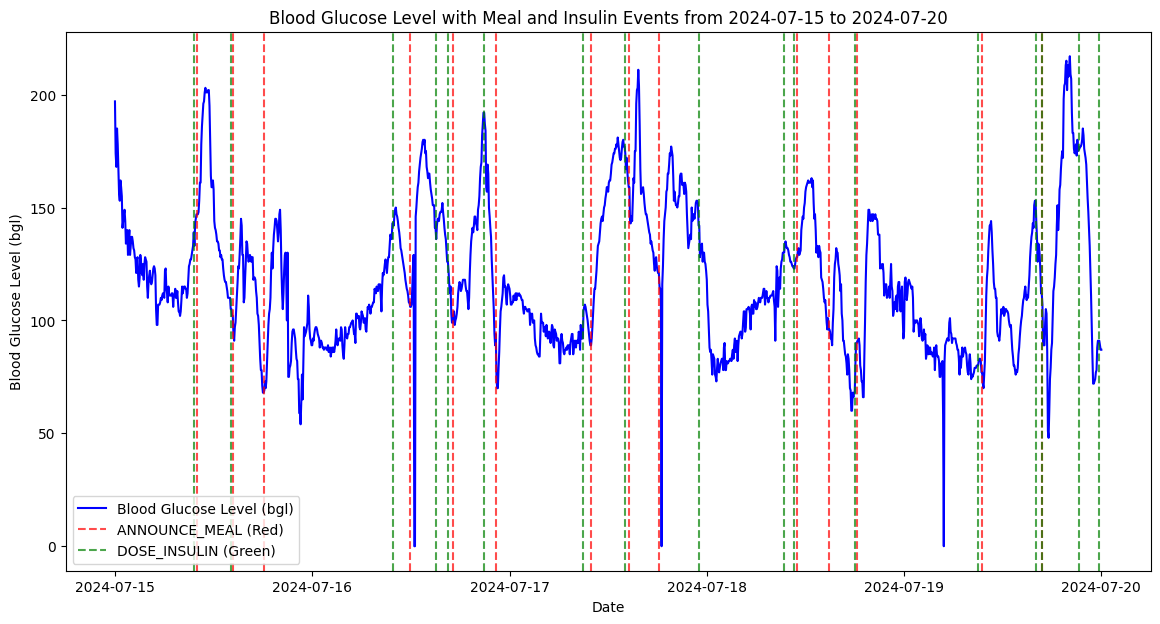

In [ ]:
plot_bgl_with_events(walker_df, start_date="2024-07-15", end_date="2024-07-20")

https://chatgpt.com/g/g-vgPJIyCzQ-gluroo/c/6731331f-0c14-8012-956f-f7863b76f0a6